# Download Data

In [1]:
import os
import requests
from urllib.parse import urljoin

base_url = "https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/monthly_1min/"

save_dir = "C:/Users/feixi/Desktop/deltaB/data/omni/high_res_1min/"

# Check and create directory if not exists
os.makedirs(save_dir, exist_ok=True)

# Download everything from 1995 to 2022
for year in range(1995, 2023):
    for month in range(1, 13):
        # Construct the filename and its URL
        filename = f"omni_min{year}{str(month).zfill(2)}.asc"
        file_url = urljoin(base_url, filename)

        # Attempt to download the file
        response = requests.get(file_url, stream=True)

        # If the download is successful, save the file
        if response.status_code == 200:
            with open(os.path.join(save_dir, filename), 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
        else:
            print(f"Failed to download {filename}.")

print("Download complete.")

Download complete.


# Load Data

In [2]:
import time
from rich.progress import track
import os
import pandas as pd
import geopack
import datetime
import pyspedas
import pytplot
from pytplot import tplot
import geopack.geopack as gp
from datetime import datetime
import numpy as np
import datetime

In [3]:

# Define the directory where downloaded files are saved
save_dir = "C:/Users/feixi/Desktop/deltaB/data/omni/high_res_1min/"

# Define the time range
start_year, start_month = 1995, 1
end_year, end_month = 2022, 12

# Prepare an empty DataFrame to hold the data
df = pd.DataFrame()

# Loop through each year and month
for year in track(range(start_year, end_year+1)):
    for month in range(1, 13):
        if year == start_year and month < start_month:
            continue
        if year == end_year and month > end_month:
            break
        # Construct the filename
        filename = f"omni_min{year}{str(month).zfill(2)}.asc"
        file_path = os.path.join(save_dir, filename)

        # Check if the file exists
        if os.path.isfile(file_path):
            # Read the file into a DataFrame
            df_temp = np.loadtxt(file_path)  # Add delimiter or other arguments if needed
            # Append the data to the main DataFrame
#           df = df.append(pd.DataFrame(df_temp))
            df = pd.concat([df, pd.DataFrame(df_temp)], ignore_index=True)
        else:
            print(f"{filename} not found.")

# Function to convert year, day of year, hour, and minute into a datetime object
def convert_to_datetime(row):
    return datetime.datetime(int(row[0]), 1, 1, int(row[2]), int(row[3])) + pd.Timedelta(days=int(row[1])-1)

# Apply the function to each row in the DataFrame
df['Datetime'] = df.apply(convert_to_datetime, axis=1)

# Set the new datetime column as the index
df.set_index('Datetime', inplace=True)
# Rename columns
df.drop(columns=df.columns[:4], axis=1, inplace=True)
df.columns = ['ID for IMF spacecraft', 'ID for SW Plasma spacecraft', '# of points in IMF averages', 
              '# of points in Plasma averages', 'Percent interp', 'Timeshift, sec', 'RMS, Timeshift', 
              'RMS, Phase front normal', 'Time btwn observations, sec', 'Field magnitude average', 
              'Bx, nT (GSE, GSM)', 'By, nT (GSE)', 'Bz, nT (GSE)', 'By, nT (GSM)', 'Bz, nT (GSM)', 'RMS SD B scalar',
              'RMS SD field vector', 'Flow speed, km/s', 'Vx Velocity, km/s, GSE', 'Vy Velocity, km/s, GSE', 
              'Vz Velocity, km/s, GSE', 'Proton Density, n/cc', 'Temperature, K', 'Flow pressure, nPa', 
              'Electric field, mV/m', 'Plasma beta', 'Alfven mach number', 'X(s/c), GSE, Re', 'Y(s/c), GSE, Re', 
              'Z(s/c), GSE, Re', 'BSN location, Xgse, Re', 'BSN location, Ygse, Re', 'BSN location, Zgse, Re',
              'AE-index, nT', 'AL-index, nT', 'AU-index, nT', 'SYM/D index, nT', 'SYM/H index, nT', 
              'ASY/D index, nT', 'ASY/H index, nT', 'Na/Np Ratio', 'Magnetosonic mach number']
df.to_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/OMNI_raw.pkl")
print("Data loading complete.")

Output()

Data loading complete.


# Let's start from here if locally

In [1]:
import time
from rich.progress import track
import os
import pandas as pd
import geopack
import datetime
import pyspedas
import pytplot
from pytplot import tplot
import geopack.geopack as gp
from datetime import datetime
import numpy as np
import datetime
import logging
import requests
from pytplot import time_double
from pytplot import time_clip as tclip
from pytplot import store_data, options
from pyspedas.utilities.dailynames import dailynames
import re
from matplotlib import pyplot as plt
import random

Load IGRF coefficients ...


In [ ]:
df = pd.read_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/OMNI_raw.pkl")
df = df[['Bx, nT (GSE, GSM)', 'By, nT (GSM)', 'Bz, nT (GSM)', 'Vx Velocity, km/s, GSE',
         'Proton Density, n/cc', 'Temperature, K']]

replace missing value with NA, and we only remove large chunks of NA values (15 or more consecutive NAs in any column)

In [5]:
df = df.replace(999.99, np.nan)
df = df.replace(9999.99, np.nan)
df = df.replace(99999.9, np.nan)
df = df.replace(9999999., np.nan)
for col in df.columns:
    mask = df[col].notna()
    a = mask.ne(mask.shift()).cumsum()
    df = df[(a.groupby(a).transform('size') < 15) | mask]
df = df.ffill()

In [6]:
# # df = df[['Bx, nT (GSE, GSM)', 'By, nT (GSE)','Bz, nT (GSE)', 'Vx Velocity, km/s, GSE',
# #        'Vy Velocity, km/s, GSE', 'Vz Velocity, km/s, GSE', 'Proton Density, n/cc', 'Temperature, K', 
# #          'Flow pressure, nPa', 'Electric field, mV/m']]
# ## use Bx,By,Bz in GSM coordinate system
# ## select data from year 2001 to year 2015
# df = df.loc['2001-01-01':'2016-01-02']
# ## drop na values
# df = df.drop(df[df['Bx, nT (GSE, GSM)'] == 9999.99].index)
# df = df.drop(df[df['By, nT (GSM)'] == 9999.99].index)
# df = df.drop(df[df['Bz, nT (GSM)'] == 9999.99].index)
# df = df.drop(df[df['Vx Velocity, km/s, GSE'] == 99999.9].index)
# # df = df.drop(df[df['Vy Velocity, km/s, GSE'] == 99999.9].index)
# # df = df.drop(df[df['Vz Velocity, km/s, GSE'] == 99999.9].index)
# df = df.drop(df[df['Proton Density, n/cc'] == 999.99].index)
# df = df.drop(df[df['Temperature, K'] == 9999999.].index)
# # df = df.drop(df[df['Flow pressure, nPa'] == 99.99].index)
# # df = df.drop(df[df['Electric field, mV/m'] == 999.99].index)
# # df = df.drop(df[df['SYM/H index, nT'] == 99999].index)

In [7]:
## start time
epoch_time = datetime.datetime(1970,1,1)
## Time since 1970-01-01
delta = df.index - epoch_time
## universal time
ut = delta.total_seconds()

In [8]:
## I should rewrite gp.recalc in the future if I have time. Only dipole tilt angle is desired here. 
ps_list = []
for i in track(range(len(ut.values))):
    ps = gp.recalc(ut.values[i])
    ps_list.append(ps)
df["Dipole Tilt Angle"] = ps_list
df.to_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/OMNI_DTA.pkl")

Output()

# F10.7 data from OMNI low resolution 1 hour average

data available at https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

In [3]:
df = pd.read_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/OMNI_DTA.pkl")

In [4]:
lowres_data = np.genfromtxt("C:/Users/feixi/Desktop/deltaB/data/omni/low_res_1h/omni2_all_years.dat",
                     skip_header=0)

In [5]:
def get_month_day(row):
    year = int(row[0])
    numday = int(row[1])
    numhour = int(row[2])
    start_date = datetime.datetime(year=year,month=1,day=1)
    deltaT = datetime.timedelta(days=numday-1, hours=numhour)
    return start_date + deltaT

In [6]:
lowres_time = np.apply_along_axis(get_month_day, 1, lowres_data[:, 0:3])
F10_7 = pd.DataFrame(lowres_data[:, 50])
F10_7.columns = ["f10.7_index"]
F10_7.index = lowres_time
F10_7 = F10_7.replace(999.9, np.nan).ffill()
F10_7 = F10_7.resample('1T').ffill()
df_joint = df.join(F10_7)

## Now let's get Dst

In [7]:
def parse_html(html_text, year=None, month=None):
    """
    Parses the HTML content to extract relevant information.

    Parameters
    ----------
    html_text : str
        The HTML content to parse.
    year : int, optional
        The year to consider while parsing the HTML content. If not provided, all years are considered.
    month : int, optional
        The month to consider while parsing the HTML content. If not provided, all months are considered.

    Returns
    -------
    dict
        A dictionary containing the parsed information.
    """
    times = []
    data = []
    # remove all of the HTML before the table
    html_data = html_text[html_text.find("Hourly Equatorial Dst Values") :]
    # remove all of the HTML after the table
    html_data = html_data[: html_data.find("<!-- vvvvv S yyyymm_part3.html vvvvv -->")]
    html_lines = html_data.split("\n")
    data_strs = html_lines[5:]
    # loop over days
    for day_str in data_strs:
        # the first element of hourly_data is the day, the rest are the hourly Dst values
#         hourly_data = day_str.split()
        hourly_data = re.findall(r'[-+]?\d+', day_str)
        if len(hourly_data[1:]) != 24:
            continue
        for idx, dst_value in enumerate(hourly_data[1:]):
            times.append(
                time_double(
                    year + "-" + month + "-" + hourly_data[0] + "/" + str(idx) + ":30"
                )
            )
            data.append(float(dst_value))

    return (times, data)


def my_dst(
    trange=None,
    time_clip=True,
    remote_data_dir="http://wdc.kugi.kyoto-u.ac.jp/",
    suffix="",
):
    """
    Loads Dst index data from the Kyoto servers.

    Parameters
    ----------
    trange : list of str, required
        Time range of interest with the format ['YYYY-MM-DD','YYYY-MM-DD'] or
        to specify more or less than a day ['YYYY-MM-DD/hh:mm:ss','YYYY-MM-DD/hh:mm:ss'].
    time_clip : bool, optional
        Time clip the variables to exactly the range specified in the trange keyword.
        Defaults to True.
    remote_data_dir : str, optional
        The remote directory from where to load the Dst index data.
        Defaults to "http://wdc.kugi.kyoto-u.ac.jp/".
    suffix : str, optional
        The tplot variable names will be given this suffix.
        By default, no suffix is added.

    Returns
    -------
    list
        List of tplot variables created.

    Examples
    --------
    >>> from pyspedas.kyoto import dst
    >>> dst_data = dst(trange=['2015-01-01', '2015-01-02'])
    >>> print(dst_data)
    kyoto_dst

    Acknowledgment
    --------------
        The DST data are provided by the World Data Center for Geomagnetism, Kyoto, and
        are not for redistribution (http://wdc.kugi.kyoto-u.ac.jp/). Furthermore, we thank
        the geomagnetic observatories (Kakioka [JMA], Honolulu and San Juan [USGS], Hermanus
        [RSA], Alibag [IIG]), NiCT, INTERMAGNET, and many others for their cooperation to
        make the Dst index available.
    """

    if trange is None:
        logging.error("trange keyword required to download data.")
        return

    try:
        file_names = dailynames(file_format="%Y%m/index.html", trange=trange)
    except Exception as e:
        logging.error("Error occurred while getting file names: " + str(e))
        return

    times = []
    data = []
    datatype = ""

    # Final files
    for filename in file_names:
        html_text = requests.get(remote_data_dir + "dst_final/" + filename).text
        file_times, file_data = parse_html(
            html_text, year=filename[:4], month=filename[4:6]
        )
        times.extend(file_times)
        data.extend(file_data)
        if len(file_times) != 0:
            datatype = "Final"

    # Provisional files
    for filename in file_names:
        html_text = requests.get(remote_data_dir + "dst_provisional/" + filename).text
        file_times, file_data = parse_html(
            html_text, year=filename[:4], month=filename[4:6]
        )
        times.extend(file_times)
        data.extend(file_data)
        if len(file_times) != 0:
            datatype = "Provisional"

    # Real Time files
    for filename in file_names:
        html_text = requests.get(remote_data_dir + "dst_realtime/" + filename).text
        file_times, file_data = parse_html(
            html_text, year=filename[:4], month=filename[4:6]
        )
        times.extend(file_times)
        data.extend(file_data)
        if len(file_times) != 0:
            datatype = "Real Time"

    if len(times) == 0:
        logging.error("No data found.")
        return

    store_data("kyoto_dst" + suffix, data={"x": times, "y": data})

    if time_clip:
        tclip("kyoto_dst" + suffix, trange[0], trange[1], suffix="")

    options("kyoto_dst" + suffix, "ytitle", "Dst (" + datatype + ")")

    logging.info(
        "**************************************************************************************"
    )
    logging.info(
        "The DST data are provided by the World Data Center for Geomagnetism, Kyoto, and"
    )
    logging.info(
        " are not for redistribution (http://wdc.kugi.kyoto-u.ac.jp/). Furthermore, we thank"
    )
    logging.info(
        " the geomagnetic observatories (Kakioka [JMA], Honolulu and San Juan [USGS], Hermanus"
    )
    logging.info(
        " [RSA], Alibag [IIG]), NiCT, INTERMAGNET, and many others for their cooperation to"
    )
    logging.info(" make the Dst index available.")
    logging.info(
        "**************************************************************************************"
    )

    return "kyoto_dst" + suffix

In [8]:
# Python package pyspedas provides a easy way to download dst data.
## downloading data from https://wdc.kugi.kyoto-u.ac.jp/index.html
dst_vars = my_dst(trange=['1995-01-01', '2023-01-02'])

05-Mar-24 15:22:15: **************************************************************************************
05-Mar-24 15:22:15: The DST data are provided by the World Data Center for Geomagnetism, Kyoto, and
05-Mar-24 15:22:15:  are not for redistribution (http://wdc.kugi.kyoto-u.ac.jp/). Furthermore, we thank
05-Mar-24 15:22:15:  the geomagnetic observatories (Kakioka [JMA], Honolulu and San Juan [USGS], Hermanus
05-Mar-24 15:22:15:  [RSA], Alibag [IIG]), NiCT, INTERMAGNET, and many others for their cooperation to
05-Mar-24 15:22:15:  make the Dst index available.
05-Mar-24 15:22:15: **************************************************************************************


In [9]:
dst = pytplot.data_quants['kyoto_dst']
df_dst = pd.DataFrame(dst.to_numpy())
df_dst.columns = ["Dst"]
df_dst.index = dst.time.to_numpy()
df_dst = df_dst.resample('1T').ffill()
df_joint_dst = df_joint.join(df_dst)
## now let's fill all missing data with the nearest data prior to this point, so we avoid using data from future.
df_joint_dst = df_joint_dst.fillna(method='ffill').loc["1995-01-01":"2023"].dropna()

In [22]:
df_joint_dst.to_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/OMNI_PhysicsInformedCols_1995_2022.pkl")

## Let's identify the storms with Dst < -50 nT.

## we apply an algorithm to find local minima.

In [10]:
from scipy.signal import argrelextrema
dst = pytplot.data_quants['kyoto_dst']
df_dst = pd.DataFrame(dst.to_numpy())
df_dst.columns = ["Dst"]
df_dst.index = dst.time.to_numpy()
df_dst.to_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/Dst_1995_2022.pkl")

In [12]:
## We find the local minima using a 5-hour window.
Dst_localMin = df_dst.iloc[argrelextrema(df_dst.Dst.values,
                                         np.less_equal,
                                         order=36)[0]]

In [9]:
Storm_date = Dst_localMin[Dst_localMin['Dst'] < -50].index

In [16]:
Dst_condition = Dst_localMin[Dst_localMin['Dst'] < -50]

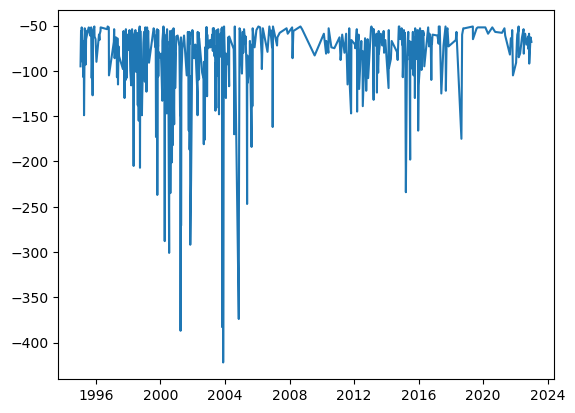

In [17]:
plt.plot(Dst_condition.index, Dst_condition['Dst'])

In [117]:
Dst_localMin[(Dst_localMin['Dst'] > -100) & (Dst_localMin['Dst'] < -50)]

,Dst
2000-06-08 19:30:00,-90.0
2021-10-17 23:30:00,-55.0
2016-02-16 19:30:00,-65.0


In [114]:
Dst_localMin[(Dst_localMin['Dst'] < -100) & (Dst_localMin['Dst'] > -200)]

,Dst
2005-01-18 08:30:00,-103.0
2002-04-20 08:30:00,-149.0
2000-10-05 13:30:00,-182.0
2004-04-04 00:30:00,-117.0
2012-07-15 18:30:00,-139.0


In [115]:
Dst_localMin[Dst_localMin['Dst'] < -200].sample(n=2, random_state=156468)

,Dst
2000-07-16 00:30:00,-301.0
2005-05-15 08:30:00,-247.0


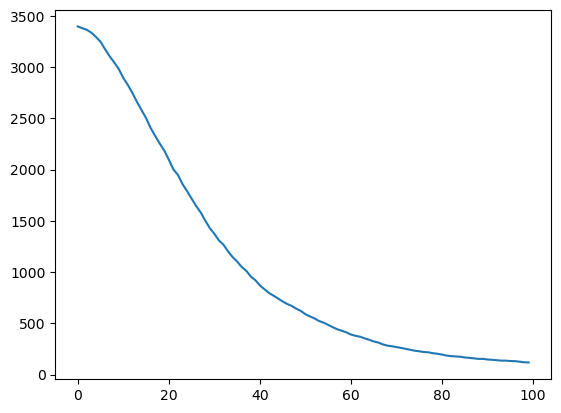

In [32]:
plt.plot([len(Dst_localMin[Dst_localMin['Dst'] < -x].index) for x in range(100)])

In [36]:
Storm_date = Dst_localMin[Dst_localMin['Dst'] < -30].index
Storm_data = []
for i in range(len(Storm_date)):
    if i < len(Storm_date)-1:
        if Storm_date[i+1] - Storm_date[i] > datetime.timedelta(hours=96):
            start_date = Storm_date[i] - datetime.timedelta(hours=48)
            end_date = Storm_date[i] + datetime.timedelta(hours=48)
            Storm_data.append(df_joint_dst.loc[start_date:end_date])
        else:
            start_date = Storm_date[i] - datetime.timedelta(hours=48)
            end_date = Storm_date[i+1] - datetime.timedelta(hours=48) - datetime.timedelta(minutes=1)
            Storm_data.append(df_joint_dst.loc[start_date:end_date])
    else:
        start_date = Storm_date[i] - datetime.timedelta(hours=48)
        end_date = Storm_date[i] + datetime.timedelta(hours=48)
        Storm_data.append(df_joint_dst.loc[start_date:end_date])
#     print(start_date, end_date)
Storm_data = pd.concat(Storm_data, axis=0)

In [37]:
Storm_data.to_pickle("C:/Users/feixi/Desktop/deltaB/data/processed_data/OMNI_StormOnly_1995_2022.pkl")